<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Opt_Attack_for_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [ ]:
!git clone https://github.com/ndb796/attackbox

Cloning into 'attackbox'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 594 (delta 7), reused 14 (delta 6), pack-reused 575
Receiving objects: 100% (594/594), 74.55 MiB | 23.69 MiB/s, done.
Resolving deltas: 100% (298/298), done.
Checking out files: 100% (191/191), done.


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

import os
import time
import shutil

#### <b>Load Dataset</b>

In [ ]:
def load_model(model, filename):
    """ Load the training model """
    model.load_state_dict(torch.load(filename))


def load_cifar10_data(batch_size=1):
    """ Load MNIST data from torchvision.datasets 
        input: None
        output: minibatches of train and test sets 
    """
    # CIFAR10 Dataset
    train_dataset = torchvision.datasets.CIFAR10('./data/cifar10-py', download=True, train=True, transform=torchvision.transforms.ToTensor())
    test_dataset = torchvision.datasets.CIFAR10('./data/cifar10-py', download=True, train=False, transform=torchvision.transforms.ToTensor())

    # Data Loader (Input Pipeline)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset


test_batch_size = 1
train_loader, test_loader, train_dataset, test_dataset = load_cifar10_data(test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


#### <b>Load Pre-trained Classification Model</b>

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG_plain(nn.Module):
    def __init__(self, vgg_name, nclass, img_width=32):
        super(VGG_plain, self).__init__()
        self.img_width = img_width
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, nclass)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        width = self.img_width
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                width = width // 2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=width, stride=1)]
        return nn.Sequential(*layers)

    def predict(self, image):
        self.eval()
        image = torch.clamp(image,0,1)
        image = Variable(image, volatile=True).view(1,3, 32,32)
        if torch.cuda.is_available():
            image = image.cuda()
        output = self(image)[0]
        print(output)
        _, predict = torch.max(output.data, 1)
        return predict[0]
    
    def predict_batch(self, image):
        self.eval()
        image = torch.clamp(image,0,1)
        image = Variable(image, volatile=True)
        if torch.cuda.is_available():
            image = image.cuda()
        output = self(image)[0]
        _, predict = torch.max(output.data, 1)
        return predict


def vgg16():
    return VGG_plain('VGG16', nclass=10)


model_dir = 'attackbox/model/cifar10_vgg_plain.pth'
net = vgg16()
net = torch.nn.DataParallel(net, device_ids=[0])
load_model(net, model_dir)
net.cuda()
net.eval()

DataParallel(
  (module): VGG_plain(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, pad

In [ ]:
class PytorchModel(object):
    def __init__(self,model, bounds, num_classes):
        self.model = model
        self.model.eval()
        self.bounds = bounds
        self.num_classes = num_classes
        self.num_queries = 0

    def predict(self,image):
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        output = self.model(image)
        self.num_queries += 1
        return output
 
    def predict_prob(self,image):
        with torch.no_grad():
            image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
            if len(image.size())!=4:
                image = image.unsqueeze(0)
            output = self.model(image)
            self.num_queries += image.size(0)
        return output

    def predict_label(self, image, batch=False):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        with torch.no_grad():
            output = self.model(image)
            self.num_queries += image.size(0)
        _, predict = torch.max(output.data, 1)
        if batch:
            return predict
        else:
            return predict[0]

    def predict_ensemble(self, image):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        with torch.no_grad():
            output = self.model(image)
            output.zero_()
            for i in range(10):
                output += self.model(image)
                self.num_queries += image.size(0)

        _, predict = torch.max(output.data, 1)

        return predict[0]

    def get_num_queries(self):
        return self.num_queries

    def get_gradient(self,loss):
        loss.backward()

#### <b>Adversarial Attack</b>

In [ ]:
MAX_ITER = 1000


class OPT_attack(object):
    def __init__(self, model):
        self.model = model
        self.log = torch.ones(MAX_ITER, 2)

    def get_log(self):
        return self.log

    def attack_untargeted(self, x0, y0, alpha=0.2, beta=0.001, iterations=1500, query_limit=20000):
        """ Attack the original image and return adversarial example
            model: (pytorch model)
            train_dataset: set of training data
            (x0, y0): original image
        """
        model = self.model
        if type(x0) is torch.Tensor:
            x0 = x0.cpu().numpy()
        if type(y0) is torch.Tensor:
            y0 = y0.item()
        if (model.predict_label(x0) != y0):
            print("Fail to classify the image. No need to attack.")
            return torch.tensor(x0).cuda()

        # 공격을 위한 초기 방향(initial direction) theta 찾기 / g_theta: 거리(짧을수록 좋음)
        num_directions = 100
        best_theta, g_theta = None, float('inf')
        query_count = 0
        print("Searching for the initial direction on %d random directions: " % (num_directions))
        np.random.seed(args.seed)
        timestart = time.time()
        for i in range(num_directions):
            query_count += 1
            theta = np.random.randn(*x0.shape) # 랜덤 theta 샘플링
            if model.predict_label(x0 + theta) != y0:
                initial_lbd = LA.norm(theta)
                theta /= initial_lbd # 단위 방향 벡터
                lbd, count = self.fine_grained_binary_search(model, x0, y0, theta, initial_lbd, g_theta)
                query_count += count
                if lbd < g_theta: # 더 짧은 거리(g_theta)를 찾았다면
                    best_theta, g_theta = theta, lbd
                    print("--------> Found distortion %.4f" % g_theta)
        if g_theta == float('inf'): # 만약 적절한 theta를 찾지 못했다면 500회 더 반복
            num_directions = 500
            best_theta, g_theta = None, float('inf')
            print("Searching for the initial direction on %d random directions: " % (num_directions))
            timestart = time.time()
            for i in range(num_directions):
                query_count += 1
                theta = np.random.randn(*x0.shape) # 랜덤 theta 샘플링
                if model.predict_label(x0 + theta) != y0:
                    initial_lbd = LA.norm(theta)
                    theta /= initial_lbd # 단위 방향 벡터
                    lbd, count = self.fine_grained_binary_search(model, x0, y0, theta, initial_lbd, g_theta)
                    query_count += count
                    if lbd < g_theta: # 더 짧은 거리(g_theta)를 찾았다면
                        best_theta, g_theta = theta, lbd
                        print("--------> Found distortion %.4f" % g_theta)

        if g_theta == float('inf'):    
            print("Couldn't find valid initial, failed")
            return torch.tensor(x0).cuda()
        timeend = time.time()
        print("==========> Found best distortion %.4f in %.4f seconds using %d queries" % (g_theta, timeend - timestart, query_count))    
        self.log[0][0], self.log[0][1] = g_theta, query_count

        # 반복적으로 theta를 업데이트하며 공격 수행
        timestart = time.time()
        g1 = 1.0
        theta, g2 = best_theta, g_theta
        opt_count = 0
        stopping = 0.01
        prev_obj = 100000
        for i in range(iterations):
            # theta의 기울기(gradient) 예측
            gradient = np.zeros(theta.shape)
            q = 10
            min_g1 = float('inf')
            for _ in range(q):
                u = np.random.randn(*theta.shape)
                u /= LA.norm(u)
                ttt = theta+beta * u
                ttt /= LA.norm(ttt)
                g1, count = self.fine_grained_binary_search_local(model, x0, y0, ttt, initial_lbd = g2, tol=beta/500)
                opt_count += count
                gradient += (g1 - g2) / beta * u # 기울기 구하기
                if g1 < min_g1:
                    min_g1 = g1
                    min_ttt = ttt
            gradient = 1.0 / q * gradient

            # 쿼리 한도(query limit)를 초과했다면 종료
            if opt_count > query_limit:
                break

            # 공격이 진행되는 상황에서 로깅(logging)
            if (i + 1) % 10 == 0:
                print("Iteration %3d distortion %.4f num_queries %d" % (i + 1, LA.norm(g2 * theta), opt_count))
                prev_obj = g2
            self.log[i+1][0], self.log[i+1][1] = g2, opt_count + query_count

            if (i + 1) % 50 == 0:
                # 화면에 이미지 출력하기
                img = torch.tensor(x0 + g2 * theta, dtype=torch.float) # [batch_size, 1, H, W]
                img = torch.clamp(img, min=0, max=1).squeeze(0) # [1, H, W]
                img = torchvision.transforms.ToPILImage()(img)
                plt.imshow(img)
                plt.show()

            # 예측된 기울기를 이용하여 theta를 업데이트할 것임
            min_theta = theta
            min_g2 = g2

            for _ in range(15): # 예측된 기울기를 이용해 alpha만큼 업데이트했을 때 거리(g_2)가 줄어드는지 확인하여 기록
                new_theta = theta - alpha * gradient
                new_theta /= LA.norm(new_theta)
                new_g2, count = self.fine_grained_binary_search_local(model, x0, y0, new_theta, initial_lbd = min_g2, tol=beta/500)
                opt_count += count
                alpha = alpha * 2
                if new_g2 < min_g2:
                    min_theta = new_theta 
                    min_g2 = new_g2
                else:
                    break

            if min_g2 >= g2: # 필요하다면 alpha를 조금 더 줄여서 거리(g_2)가 줄어드는지 다시 확인하여 기록
                for _ in range(15):
                    alpha = alpha * 0.25
                    new_theta = theta - alpha * gradient
                    new_theta /= LA.norm(new_theta)
                    new_g2, count = self.fine_grained_binary_search_local(model, x0, y0, new_theta, initial_lbd = min_g2, tol=beta/500)
                    opt_count += count
                    if new_g2 < g2:
                        min_theta = new_theta 
                        min_g2 = new_g2
                        break

            # 결과적으로 theta(방향)와 g_theta(거리) 정보를 업데이트
            if min_g2 <= min_g1:
                theta, g2 = min_theta, min_g2
            else:
                theta, g2 = min_ttt, min_g1

            if g2 < g_theta:
                best_theta, g_theta = theta, g2

            if alpha < 1e-4:
                alpha = 1.0
                print("Warning: not moving, g2 %lf gtheta %lf" % (g2, g_theta))
                beta = beta * 0.1
                if (beta < 1e-8):
                   break

        target = model.predict_label(x0 + g_theta * best_theta)
        timeend = time.time()
        print("\nAdversarial Example Found Successfully: distortion %.4f target %d queries %d \nTime: %.4f seconds" % (g_theta, target, query_count + opt_count, timeend-timestart))

        self.log[i+1:,0] = g_theta
        self.log[i+1:,1] = opt_count + query_count
        return torch.tensor(x0 + g_theta * best_theta, dtype=torch.float).cuda()

    # theta를 업데이트할 때 사용
    def fine_grained_binary_search_local(self, model, x0, y0, theta, initial_lbd=1.0, tol=1e-5):
        nquery = 0
        lbd = initial_lbd

        if model.predict_label(x0 + lbd * theta) == y0:
            lbd_lo = lbd
            lbd_hi = lbd * 1.01
            nquery += 1
            while model.predict_label(x0 + lbd_hi * theta) == y0:
                lbd_hi = lbd_hi * 1.01
                nquery += 1
                if lbd_hi > 20:
                    return float('inf'), nquery
        else:
            lbd_hi = lbd
            lbd_lo = lbd * 0.99
            nquery += 1
            while model.predict_label(x0 + lbd_lo * theta) != y0 :
                lbd_lo = lbd_lo * 0.99
                nquery += 1

        while (lbd_hi - lbd_lo) > tol:
            lbd_mid = (lbd_lo + lbd_hi) / 2.0
            nquery += 1
            if model.predict_label(x0 + lbd_mid * theta) != y0:
                lbd_hi = lbd_mid
            else:
                lbd_lo = lbd_mid
        return lbd_hi, nquery

    # 처음에 initial theta를 찾을 때 사용
    def fine_grained_binary_search(self, model, x0, y0, theta, initial_lbd, current_best):
        nquery = 0
        if initial_lbd > current_best: 
            if model.predict_label(x0 + current_best * theta) == y0:
                nquery += 1
                return float('inf'), nquery
            lbd = current_best
        else:
            lbd = initial_lbd

        lbd_hi = lbd
        lbd_lo = 0.0

        while (lbd_hi - lbd_lo) > 1e-5:
            lbd_mid = (lbd_lo + lbd_hi) / 2.0
            nquery += 1
            if model.predict_label(x0 + lbd_mid * theta) != y0:
                lbd_hi = lbd_mid
            else:
                lbd_lo = lbd_mid
        return lbd_hi, nquery

    def __call__(self, input_xi, label_or_target, TARGETED=False, epsilon=None):
        if TARGETED:
            print("Not Implemented.")
        else:
            adv = self.attack_untargeted(input_xi, label_or_target)
        return adv

In [ ]:
# 단순히 p-norm 거리(distance) 계산
def distance(x_adv, x, norm='l2'):
    diff = (x_adv - x).view(x.size(0), -1)
    if norm == 'l2':
        out = torch.sqrt(torch.sum(diff * diff)).item()
        return out
    elif norm == 'linf':
        out = torch.sum(torch.max(torch.abs(diff), 1)[0]).item()
        return out

In [ ]:
from types import SimpleNamespace

args = SimpleNamespace()

args.attack = 'OPT_attack' # Attack to be used.
args.targeted = False # Targeted attack.
args.random_start = False # PGD attack with random start.
args.epsilon = 1.0
args.seed = 123
args.norm = 'l2'
args.test_batch = 3 # The number of test batch.

image batch: 0
Searching for the initial direction on 100 random directions: 
--------> Found distortion 3.7202
--------> Found distortion 3.7017
--------> Found distortion 3.5716
--------> Found distortion 2.9893
--------> Found distortion 2.8506
--------> Found distortion 2.7356
==========> Found best distortion 2.7356 in 3.2823 seconds using 312 queries
Iteration  10 distortion 1.8053 num_queries 2103
Iteration  20 distortion 1.0979 num_queries 4027
Iteration  30 distortion 0.8589 num_queries 5969
Iteration  40 distortion 0.7311 num_queries 7772
Iteration  50 distortion 0.6423 num_queries 9536


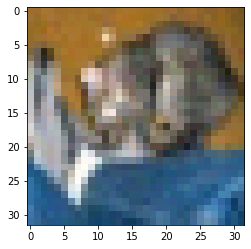

Iteration  60 distortion 0.5951 num_queries 11179
Iteration  70 distortion 0.5617 num_queries 12839
Iteration  80 distortion 0.5255 num_queries 14509
Iteration  90 distortion 0.4884 num_queries 16200
Iteration 100 distortion 0.4657 num_queries 17840


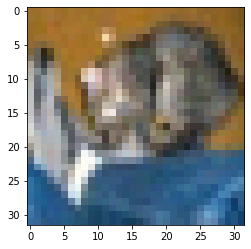

Iteration 110 distortion 0.4451 num_queries 19486

Adversarial Example Found Successfully: distortion 0.4412 target 6 queries 20440 
Time: 212.0795 seconds


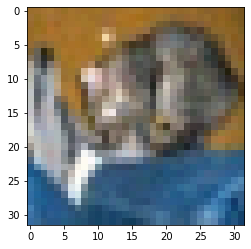

image batch: 1
Searching for the initial direction on 100 random directions: 
--------> Found distortion 4.5299
--------> Found distortion 4.0619
--------> Found distortion 3.9259
--------> Found distortion 3.8379
--------> Found distortion 3.4344
--------> Found distortion 3.3284
==========> Found best distortion 3.3284 in 3.1464 seconds using 312 queries
Iteration  10 distortion 2.0991 num_queries 2245
Iteration  20 distortion 1.7654 num_queries 4296
Iteration  30 distortion 1.4610 num_queries 6263
Iteration  40 distortion 1.0342 num_queries 8254
Iteration  50 distortion 0.7985 num_queries 10143


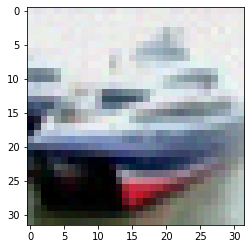

Iteration  60 distortion 0.6608 num_queries 11884
Iteration  70 distortion 0.5963 num_queries 13592
Iteration  80 distortion 0.5478 num_queries 15331
Iteration  90 distortion 0.5143 num_queries 17071
Iteration 100 distortion 0.4827 num_queries 18770


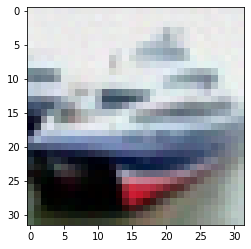


Adversarial Example Found Successfully: distortion 0.4606 target 1 queries 20410 
Time: 212.6560 seconds


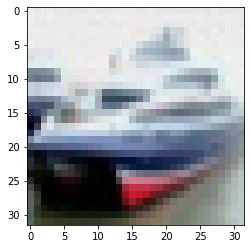

image batch: 2
Searching for the initial direction on 100 random directions: 
--------> Found distortion 2.2699
--------> Found distortion 1.8510
--------> Found distortion 1.6913
--------> Found distortion 1.5024
==========> Found best distortion 1.5024 in 2.7768 seconds using 273 queries
Iteration  10 distortion 0.8068 num_queries 1969
Iteration  20 distortion 0.6085 num_queries 3722
Iteration  30 distortion 0.5042 num_queries 5532
Iteration  40 distortion 0.4492 num_queries 7233
Iteration  50 distortion 0.4066 num_queries 8893


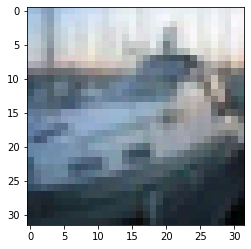

Iteration  60 distortion 0.3604 num_queries 10573
Iteration  70 distortion 0.3374 num_queries 12166
Iteration  80 distortion 0.3159 num_queries 13751
Iteration  90 distortion 0.2970 num_queries 15362
Iteration 100 distortion 0.2859 num_queries 16886


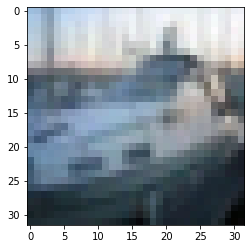

Iteration 110 distortion 0.2694 num_queries 18447
Iteration 120 distortion 0.2587 num_queries 19946

Adversarial Example Found Successfully: distortion 0.2581 target 9 queries 20365 
Time: 214.3301 seconds


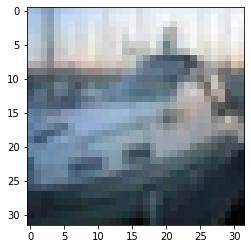

image batch: 3
saving logs to numpy array


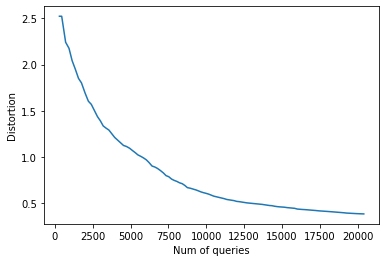

In [ ]:
amodel = PytorchModel(net, bounds=[0, 1], num_classes=10)
attack = OPT_attack(amodel)

total_r_count = 0
total_clean_count = 0
total_distance = 0

for i, (xi, yi) in enumerate(test_loader):
    print(f"image batch: {i}")
    if i == args.test_batch:
        break

    xi, yi = xi.cuda(), yi.cuda()
    adv = attack(xi, yi, epsilon=args.epsilon, TARGETED=args.targeted)

    # 결과 출력(l_2 distortion이 충분히 감소했을 때 성공)
    img = torchvision.transforms.ToPILImage()(torch.clamp(adv, min=0, max=1).squeeze(0))
    plt.imshow(img)
    plt.show()

    if args.targeted == False:
        r_count = (torch.max(amodel.predict(adv), 1)[1] == yi).nonzero().shape[0]
        clean_count = (torch.max(amodel.predict(xi), 1)[1] == yi).nonzero().shape[0]
        total_r_count += r_count
        total_clean_count += clean_count
        total_distance += distance(adv, xi, norm=args.norm)

    if i == 0:
        logs = torch.zeros(attack.get_log().size())
    logs += attack.get_log()

logs /= args.test_batch
print("saving logs to numpy array")
npy_file = "log.npy"
np.save(npy_file,logs.numpy())

plot_log = np.load(npy_file)
plt.plot(plot_log[:,1], plot_log[:,0])
plt.ylabel('Distortion')
plt.xlabel('Num of queries')
plt.show()